In [ ]:
!pip install diffusers
!pip install transformers
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install tensorboard
!pip install accelerate

# Feature Extraction
## Extract the Vector Representation of the input text

In [ ]:
from transformers import BartTokenizer, BartModel

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartModel.from_pretrained('facebook/bart-large')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
print (inputs)
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
# The shape is in form of (batch_size, seq_len, embedding_dim)
print(last_hidden_states.shape, '\n')
print(last_hidden_states)

{'input_ids': tensor([[    0, 31414,     6,   127,  2335,    16, 11962,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
torch.Size([1, 8, 1024]) 

tensor([[[ 0.5512,  0.8389, -1.4707,  ...,  1.3124, -0.2047,  0.2392],
         [ 0.5512,  0.8389, -1.4707,  ...,  1.3124, -0.2047,  0.2392],
         [ 0.9143,  0.9399, -1.2426,  ...,  0.9183, -0.1838, -0.9975],
         ...,
         [ 0.2561,  0.2253,  0.4470,  ...,  0.3447,  0.0087,  1.5508],
         [ 0.2077, -1.3086, -1.4295,  ..., -0.2998,  0.1828,  0.4700],
         [-0.4893,  2.5148, -1.5513,  ...,  0.5783,  1.0961,  0.1736]]],
       grad_fn=<NativeLayerNormBackward0>)


## Compare two text

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Instantiate the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

# Sentence pairs
sentence1 = ''' Let me start by saying this is an awesome case! The cover for the screen and molding for the body of the phone are great. I've dropped it a few times and it is really sturdy. It fits in to all my holders in my cars fully protects my phone. My only problem was the color I PICKED! The gold looked good in the picture on my phone, however when I got the case it was more vanilla than gold. I'll probably order another one in black for me and one for my niece. Great case! '''
sentence2 = '''While this product is absolutely awesome when installed, it looks and feels great, I have to admit it is a little bit hard to get apart initially! Had to have my husband take it apart for me! Not easy for those with tender hands or fingers! That being said, it really is a wonderful product! The glass goes on flawlessly without bubbles and the phone is totally encased for protection.'''

# Tokenize and format the inputs
inputs = tokenizer(sentence1, sentence2, return_tensors='pt')
# Get model's output
outputs = model(**inputs)

# Get the predicted label
predicted_label = torch.argmax(outputs.logits[0]).item()  # 0: contradiction
predicted_class = model.config.id2label[predicted_label]

print(f"The predicted class for the first pair is: {predicted_class}")

The predicted class for the first pair is: neutral


# Text-to-Image

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/900 [00:00<?, ?it/s]

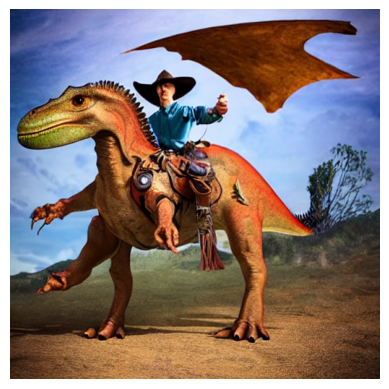

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an cowboy man riding dinosaurs in pacaso style"

# Generate images from the prompt
image = pipe(prompt,num_inference_steps=900).images[0]
plt.imshow(image)
plt.axis('off')  # No axis for clarity
plt.show()
image.save("man_riding_dinosaurs.png")


# Image-to-Text

Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.0.crossattention.bias', 'decoder.transformer.h.3.attn.masked_bias', 'decoder.transformer.h.9.attn.masked_bias', 'decoder.transformer.h.7.crossattention.bias', 'decoder.transformer.h.6.crossattention.bias', 'decoder.transformer.h.2.attn.masked_bias', 'decoder.transformer.h.8.attn.bias', 'decoder.transformer.h.3.crossattention.masked_bias', 'decoder.transformer.h.7.attn.bias', 'decoder.transformer.h.6.crossattention.masked_bias', 'decoder.transformer.h.3.crossattention.bias', 'decoder.transformer.h.5.crossattention.bias', 'decoder.transformer.h.4.attn.masked_bias', 'decoder.transformer.h.8.attn.masked_bias', 'decoder.transformer.h.4.attn.bias', 'decoder.transformer.h.9.crossattention.bias', 'decoder.transformer.h.2.crossattention.masked_bias', 'decoder.transformer.h.0.crossattention.masked_bias', 'decoder.transformer.h.11.crossatt

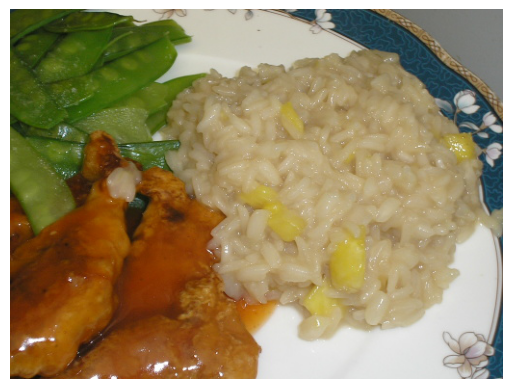

Predicted Caption: a white plate topped with rice and vegetables


In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Load pretrained model and processor
image_caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
token_processor = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Select device based on availability
execution_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_caption_model.to(execution_device)

# Set parameters for image captioning generation
max_caption_length = 16
beam_search_width = 4
generation_parameters = {"max_length": max_caption_length, "num_beams": beam_search_width}

# Freely available image from Unsplash
image_url = 'https://raw.githubusercontent.com/bpbpublications/Building-Transformer-Models-with-PyTorch/main/chapter8_CVTask/food_image.jpg'

# Get image from URL
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
if img.mode != "RGB":
    img = img.convert(mode="RGB")

# Display the image
plt.imshow(img)
plt.axis('off')  # No axis for clarity
plt.show()

# Extract features from the image
pixel_values = image_processor(images=[img], return_tensors="pt").pixel_values
pixel_values = pixel_values.to(execution_device)

# Generate captions using the model
generated_ids = image_caption_model.generate(pixel_values, **generation_parameters)

# Decode the generated captions
generated_captions = token_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_captions = [caption.strip() for caption in generated_captions]

# Print the generated caption
print(f"Predicted Caption: {generated_captions[0]}")


Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.0.crossattention.bias', 'decoder.transformer.h.3.attn.masked_bias', 'decoder.transformer.h.9.attn.masked_bias', 'decoder.transformer.h.7.crossattention.bias', 'decoder.transformer.h.6.crossattention.bias', 'decoder.transformer.h.2.attn.masked_bias', 'decoder.transformer.h.8.attn.bias', 'decoder.transformer.h.3.crossattention.masked_bias', 'decoder.transformer.h.7.attn.bias', 'decoder.transformer.h.6.crossattention.masked_bias', 'decoder.transformer.h.3.crossattention.bias', 'decoder.transformer.h.5.crossattention.bias', 'decoder.transformer.h.4.attn.masked_bias', 'decoder.transformer.h.8.attn.masked_bias', 'decoder.transformer.h.4.attn.bias', 'decoder.transformer.h.9.crossattention.bias', 'decoder.transformer.h.2.crossattention.masked_bias', 'decoder.transformer.h.0.crossattention.masked_bias', 'decoder.transformer.h.11.crossatt

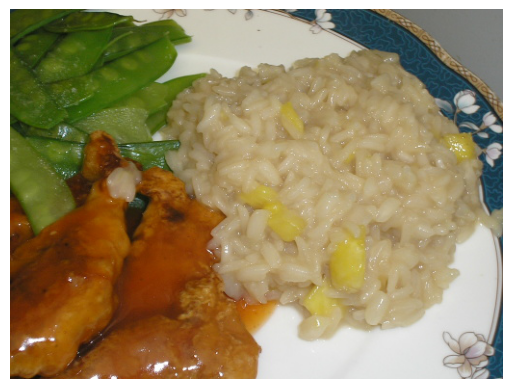

a plate of food with rice, beans, and vegetables 


In [ ]:
from transformers import pipeline

image_url = 'https://raw.githubusercontent.com/bpbpublications/Building-Transformer-Models-with-PyTorch/main/chapter8_CVTask/food_image.jpg'

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

output=image_to_text(image_url)

response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
if img.mode != "RGB":
    img = img.convert(mode="RGB")

# Display the image
plt.imshow(img)
plt.axis('off')  # No axis for clarity
plt.show()
print(output[0]['generated_text'])

# Image Question Answering


In [ ]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

# Instantiate the processor and model from the pretrained "Salesforce/blip-vqa-base"
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to("cuda")

# URL of the image for visual question answering
image_url = 'https://raw.githubusercontent.com/bpbpublications/Building-Transformer-Models-with-PyTorch/main/chapter8_CVTask/food_image.jpg'

# Request the image from the URL and convert it to RGB
raw_image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')

# The question to be asked
question = "Is there rice in the plate?"

# Prepare the inputs for the model
# This includes the image and the question, transformed to tensors and moved to the GPU
inputs = processor(raw_image, question, return_tensors="pt").to("cuda")

# Generate the answer using the model
out = model.generate(**inputs)

# Decode the output into a string answer, skipping special tokens
answer = processor.decode(out[0], skip_special_tokens=True)

# Print the answer
print(f"The answer to your question is :{answer}")


The answer to your question is :yes


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
